# Projet 1 : Quel est l'artiste

## Import des librairies

In [1]:
# Utils
import os
import shutil
import time


# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Import des données

In [3]:
!git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge.git

Cloning into 'art-challenge'...
remote: Enumerating objects: 17127, done.
remote: Counting objects: 100% (4373/4373), done.
remote: Compressing objects: 100% (4367/4367), done.
remote: Total 17127 (delta 36), reused 4251 (delta 6), pack-reused 12754 (from 1)
Receiving objects: 100% (17127/17127), 2.16 GiB | 19.70 MiB/s, done.
Resolving deltas: 100% (170/170), done.
Updating files: 100% (16806/16806), done.


In [4]:
# tf.config.list_physical_devices()
[k.device_type for k in tf.config.list_physical_devices()]

['CPU', 'GPU']

### Chargement du dataset

In [5]:
import pandas as pd

#chargement du dataset qui ce situe dans art-challenge
df_artists = pd.read_csv('art-challenge/artists.csv')

#affichage des 5 premières ligne
print(df_artists.head())

   id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/

In [6]:
df_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           50 non-null     int64 
 1   name         50 non-null     object
 2   years        50 non-null     object
 3   genre        50 non-null     object
 4   nationality  50 non-null     object
 5   bio          50 non-null     object
 6   wikipedia    50 non-null     object
 7   paintings    50 non-null     int64 
dtypes: int64(2), object(6)
memory usage: 3.2+ KB


## Analyse exploratoire

In [7]:
# nombre total de tableau ( c'est à dire somme de tout les paintings)

total_paintings = df_artists['paintings'].sum()
print(f"Nombre Total de tableau: {total_paintings}")

Nombre Total de tableau: 8446


## Prediction simple CNN

Nous devons maintenant construire un modèle qui vas nous permettre de détecter l'auteur d'un tableau. Il sagit donc d'une classifiaction d'image. Dans ce cas précis, un réseau convolutif (CNN) est particulièrement bien adaptée car les CNNs sont connus pour être performants pour l'analyse d'images.

Nous allons donc dans un premier temps en construire un "naivement"


import

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

### Chargement du data set

In [9]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Chemin vers le dossier d'images
data_dir = 'art-challenge/images_hq'

# 2. Définir les transformations pour les images   // VOIR QUEL TRANSFORMATION VEUT ON APPLIQUER//
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images à 224x224 (comme dans ResNet, VGG, etc.)
    transforms.ToTensor(),          # Convertir les images en tenseurs PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation avec des moyennes et std communes pour les images
])

# 3.ImageFolder pour charger les images , ImageFolder prend en charge tout l'import et la labelisation grâce a la structure du dossier
art_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

### Affichage de 10 images au hasard

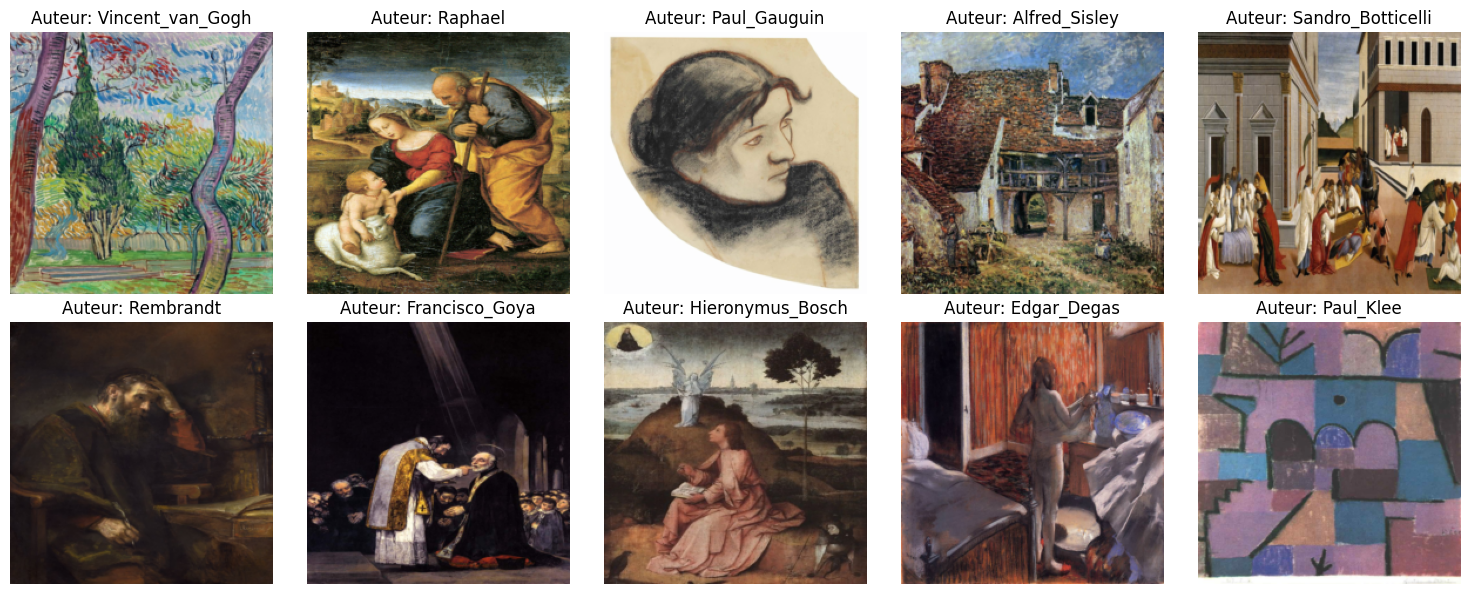

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Sélectionner 10 indices aléatoires
num_images = 10
random_indices = np.random.choice(len(art_dataset), size=num_images, replace=False)

# Créer un subplot 2x5
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, index in enumerate(random_indices):
    image, label = art_dataset[index]
    # Convertir l'image tensor en numpy array
    image_np = image.numpy().transpose((1, 2, 0))  # Transposition pour avoir les dimensions (H, W, C) au lieu de (C,H,W)
    # Dénormaliser l'image
    image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    # Clipping des valeurs en dehors de la plage 0-1
    image_np = np.clip(image_np, 0, 1)

    # Afficher l'image et le label
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image_np)
    axes[row, col].set_title(f"Auteur: {art_dataset.classes[label]}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Pré traitement des données


In [71]:
df_artists['id'] = df_artists['id'].astype('category')
df_artists.describe()

,paintings
count,50.000000
mean,168.920000
std,157.451105
min,24.000000
25%,81.000000
50%,123.000000
75%,191.750000
max,877.000000


In [11]:
#Définition du nombre min et max de tabelau
TAB_MIN = 81
TAB_MAX = 191

In [12]:
# Filtrer art_dataset pour ne garder que les lignes où le label correspond à un artiste qui apparaît au moins 81 fois et moins de 191 fois
artist_counts = {}
for _, label in art_dataset:
  if art_dataset.classes[label] not in artist_counts:
    artist_counts[art_dataset.classes[label]] = 0
  artist_counts[art_dataset.classes[label]] += 1

filtered_dataset2 = [(image, label) for image, label in art_dataset if TAB_MIN <= artist_counts[art_dataset.classes[label]] <= TAB_MAX]

# Remplacer art_dataset par le nouveau dataset filtré
art_datasetf = filtered_dataset2

# Afficher le nouveau nombre d'images dans art_dataset
print(f"Nombre d'images dans art_datasetf après filtrage : {len(art_datasetf)}")


Nombre d'images dans art_datasetf après filtrage : 3106


#### Nombre d'artiste gardés

In [13]:
# Obtenir la liste des artiste présent dans art_datasetf
unique_artists = set([art_dataset.classes[label] for _, label in art_datasetf])

# Print the number of unique artists
print("Nombre d'artistes différents dans art_datasetf:", len(unique_artists))

Nombre d'artistes différents dans art_datasetf: 25


Dans le cadre de ce projet on gardera ces 25 artistes. On pourrait faire varier ce nombre afin d'améliorer la qualité de la prédiction mais cela nous conduirais à réduire de plus en plus le nombre d'artiste. Nous décidons donc de garder les artistes qui ont entre 81 et 191 tableaux, ce qui correspond au 25 ème et 75 ème pourcentil.

Il est important que nos artistes est un nombre similaires d'oeuvre pour avoir une représentation équitable des classes, si un artiste à trop peu d'oeuvre le modèle aura tendance à ignorer cette classe, au contraire si un artiste à trop d'oeuvre le modèle pourra favoriser cette classe mais aussi faire du surapprentissage et perdre de sa flexibilité.

Garder un nombre d’œuvres équilibré tout en gardant un grand nombred'artiste, est donc essentiel pour un apprentissage plus impartial et précis du modèle sans trop réduire la compléxité du problème.

#### Mis à jour des labels

In [14]:
# Affichage des labels de art_datasetf et leur artiste correspondant

unique_labels = set([label for _, label in art_datasetf])
artist_label_mapping = {}
for _, label in art_datasetf:
    artist_name = art_dataset.classes[label]
    if artist_name not in artist_label_mapping:
        artist_label_mapping[artist_name] = label

print("Artiste et label correspondant dans art_datasetf:")
for artist, label in artist_label_mapping.items():
    print(f"Artiste: {artist}, Label: {label}")

Artiste et label correspondant dans art_datasetf:
Artiste: Andrei_Rublev, Label: 3
Artiste: Andy_Warhol, Label: 4
Artiste: Camille_Pissarro, Label: 5
Artiste: Diego_Velazquez, Label: 9
Artiste: Edouard_Manet, Label: 11
Artiste: El_Greco, Label: 13
Artiste: Frida_Kahlo, Label: 16
Artiste: Giotto_di_Bondone, Label: 18
Artiste: Gustav_Klimt, Label: 19
Artiste: Henri_Matisse, Label: 21
Artiste: Henri_de_Toulouse-Lautrec, Label: 23
Artiste: Hieronymus_Bosch, Label: 24
Artiste: Jan_van_Eyck, Label: 26
Artiste: Joan_Miro, Label: 27
Artiste: Kazimir_Malevich, Label: 28
Artiste: Leonardo_da_Vinci, Label: 29
Artiste: Mikhail_Vrubel, Label: 32
Artiste: Paul_Klee, Label: 36
Artiste: Peter_Paul_Rubens, Label: 37
Artiste: Piet_Mondrian, Label: 39
Artiste: Pieter_Bruegel, Label: 40
Artiste: Raphael, Label: 41
Artiste: Salvador_Dali, Label: 44
Artiste: Sandro_Botticelli, Label: 45
Artiste: Vasiliy_Kandinskiy, Label: 47


In [15]:
# Changement des numéro pour que la prédiction fonctionne

# Creation d'un dictionaire pour associer à chaque ancien label un nouveau label
label_mapping = {}
new_label = 0
for _, label in art_datasetf:
    if art_dataset.classes[label] not in label_mapping:
        label_mapping[art_dataset.classes[label]] = new_label
        new_label += 1

# Création du nouveau dataset avec les label mis à jour
updated_dataset = []
for image, label in art_datasetf:
    artist_name = art_dataset.classes[label]
    new_label = label_mapping[artist_name]
    updated_dataset.append((image, new_label))

# Mise à jour du dataset
art_datasetf = updated_dataset

# Affichage des nouveaux labels
unique_labels = set([label for _, label in art_datasetf])
print("Vérification des nouveau labels :", unique_labels)

Vérification des nouveau labels : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}


In [16]:
unique_labels = set([label for _, label in art_datasetf])
artist_label_mapping = {}
for _, label in art_datasetf:
    artist_name = art_dataset.classes[label]
    if artist_name not in artist_label_mapping:
        artist_label_mapping[artist_name] = label

print("Artiste et label correspondant dans art_datasetf:")
for artist, label in artist_label_mapping.items():
    print(f"Artiste: {artist}, Label: {label}")

Artiste et label correspondant dans art_datasetf:
Artiste: Albrecht_Dürer, Label: 0
Artiste: Alfred_Sisley, Label: 1
Artiste: Amedeo_Modigliani, Label: 2
Artiste: Andrei_Rublev, Label: 3
Artiste: Andy_Warhol, Label: 4
Artiste: Camille_Pissarro, Label: 5
Artiste: Caravaggio, Label: 6
Artiste: Claude_Monet, Label: 7
Artiste: Diego_Rivera, Label: 8
Artiste: Diego_Velazquez, Label: 9
Artiste: Edgar_Degas, Label: 10
Artiste: Edouard_Manet, Label: 11
Artiste: Edvard_Munch, Label: 12
Artiste: El_Greco, Label: 13
Artiste: Eugene_Delacroix, Label: 14
Artiste: Francisco_Goya, Label: 15
Artiste: Frida_Kahlo, Label: 16
Artiste: Georges_Seurat, Label: 17
Artiste: Giotto_di_Bondone, Label: 18
Artiste: Gustav_Klimt, Label: 19
Artiste: Gustave_Courbet, Label: 20
Artiste: Henri_Matisse, Label: 21
Artiste: Henri_Rousseau, Label: 22
Artiste: Henri_de_Toulouse-Lautrec, Label: 23
Artiste: Hieronymus_Bosch, Label: 24


### Definition des hyperparamètres

In [54]:
# Définition des hyperparamètres
num_epochs = 20               # Nombre d'époques d'entraînement
batch_size = 64               # Taille de chaque lot de données
learning_rate = 0.001         # Taux d'apprentissage initial pour l'optimiseur
momentum = 0.9                # Momentum pour SGD
test_split = 0.2              # Fraction des données pour le test
val_split = 0.1               # Fraction des données d'entraînement pour la validation
random_seed = 42              # Pour la reproductibilité des résultats


# Choix du device - GPU si disponible, sinon CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Transformation des données

In [55]:
# Transformations pour les données - Utilisation de la data augmentation pour le jeu d'entraînement   \\ A Intégrer Si besoin , pour l'instant transformer créer mais pas appliqué \\

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip horizontal
    transforms.RandomRotation(10),      # Rotation aléatoire de ±10°
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.ToTensor()  # Transformation en tenseur pour le test (pas de data augmentation)
])

### Séparation des données en train test et val

In [56]:

# Chargement des données
train_dataset, test_dataset = train_test_split(art_datasetf, test_size=test_split, random_state=random_seed)

# Splitting train_dataset pour validation
train_dataset, val_dataset = train_test_split(train_dataset, test_size=val_split, random_state=random_seed)

# Chargement des données avec DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Défintion du modèle CNN

In [57]:
IM_SIZE = train_dataset[10][0].shape[2]
INPUT_SHAPE = (IM_SIZE, IM_SIZE, 3)
print(INPUT_SHAPE)

(224, 224, 3)


In [58]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        # Blocs de convolution avec batch normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Adaptive pooling pour une taille de sortie constante (7x7)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Couches entièrement connectées
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))

        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))

        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))

        # Application d'un Adaptive Pooling pour s'assurer que la sortie est de la bonne taille
        x = self.adaptive_pool(x)

        x = x.view(-1, 128 * 7 * 7)  # Mise en forme pour les couches entièrement connectées

        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



### Initialisation du modèle

In [59]:
# Initialisation du modèle
num_classes = len(unique_artists)

modelI = ImprovedCNN(num_classes).to(device)

print(num_classes)

25


### Défintion de la perte et de l'optim

In [60]:
# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()  # Perte d'entropie croisée pour une classification multi-classes
optimizer = optim.SGD(modelI.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Réduit le LR tous les 10 epochs

### Definition fonction train

In [61]:
# Fonction d'entraînement
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Mode entraînement
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Remise à zéro des gradients
            outputs = model(images)
            loss = criterion(outputs, labels)  # Calcul de la perte
            loss.backward()  # Rétropropagation
            optimizer.step()  # Mise à jour des paramètres

            running_loss += loss.item()

        # Ajustement du taux d'apprentissage
        scheduler.step()

        # Validation
        val_accuracy = evaluate(model, val_loader)[0]
        print(f"Époque [{epoch+1}/{num_epochs}], Perte : {running_loss/len(train_loader):.4f}, Précision Validation : {val_accuracy:.2f}%")

### Definition fonction d'éval

In [62]:

# Fonction d'évaluation
def evaluate(model, data_loader):
    model.eval()  # Mode évaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total , predicted


### Entrainement et test

In [63]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Entraînement et validation du modèle
train(modelI, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Époque [1/20], Perte : 3.1249, Précision Validation : 14.06%
Époque [2/20], Perte : 2.8951, Précision Validation : 20.48%
Époque [3/20], Perte : 2.7337, Précision Validation : 25.30%
Époque [4/20], Perte : 2.6140, Précision Validation : 30.12%
Époque [5/20], Perte : 2.5075, Précision Validation : 31.33%
Époque [6/20], Perte : 2.4228, Précision Validation : 37.35%
Époque [7/20], Perte : 2.3290, Précision Validation : 38.96%
Époque [8/20], Perte : 2.2690, Précision Validation : 40.16%
Époque [9/20], Perte : 2.1933, Précision Validation : 40.96%
Époque [10/20], Perte : 2.1415, Précision Validation : 40.96%
Époque [11/20], Perte : 2.0760, Précision Validation : 41.37%
Époque [12/20], Perte : 2.0532, Précision Validation : 41.37%
Époque [13/20], Perte : 2.0186, Précision Validation : 43.78%
Époque [14/20], Perte : 1.9818, Précision Validation : 44.58%
Époque [15/20], Perte : 1.9468, Précision Validation : 43.78%
Époque [16/20], Perte : 1.9262, Précision Validation : 46.18%
Époque [17/20], P

In [67]:
# Évaluation finale sur le jeu de test
test_accuracy , pred_label = evaluate(modelI, test_loader)
print(f"Taux de précision sur le jeu de test : {test_accuracy:.2f}%")

Taux de précision sur le jeu de test : 43.09%


Afficher les résultats

In [68]:
import numpy as np
import random

def denormalize(image, mean, std):
    image = image * std + mean
    return np.clip(image, 0, 1)  # Clip pour garder les valeurs entre 0 et 1

def display_random_images_with_predictions(model, data_loader, class_names, num_images=10):
    model.eval()
    images_displayed = 0
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            indices = random.sample(range(len(images)), min(num_images - images_displayed, len(images)))

            for idx in indices:
                image = images[idx].cpu().numpy().transpose(1, 2, 0)

                # Dénormaliser l'image si elle a été normalisée
                image = denormalize(image, np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5]))

                real_label = labels[idx].item()
                predicted_label = predicted[idx].item()

                real_author = class_names[real_label]
                predicted_author = class_names[predicted_label]

                ax = axes[images_displayed]
                ax.imshow(image)
                ax.set_title(f"Réel: {real_author}\nPrédit: {predicted_author}")
                ax.axis('off')

                images_displayed += 1
                if images_displayed >= num_images:
                    break
            if images_displayed >= num_images:
                break

    plt.tight_layout()
    plt.show()


In [69]:
class_names = list(artist_label_mapping.keys())

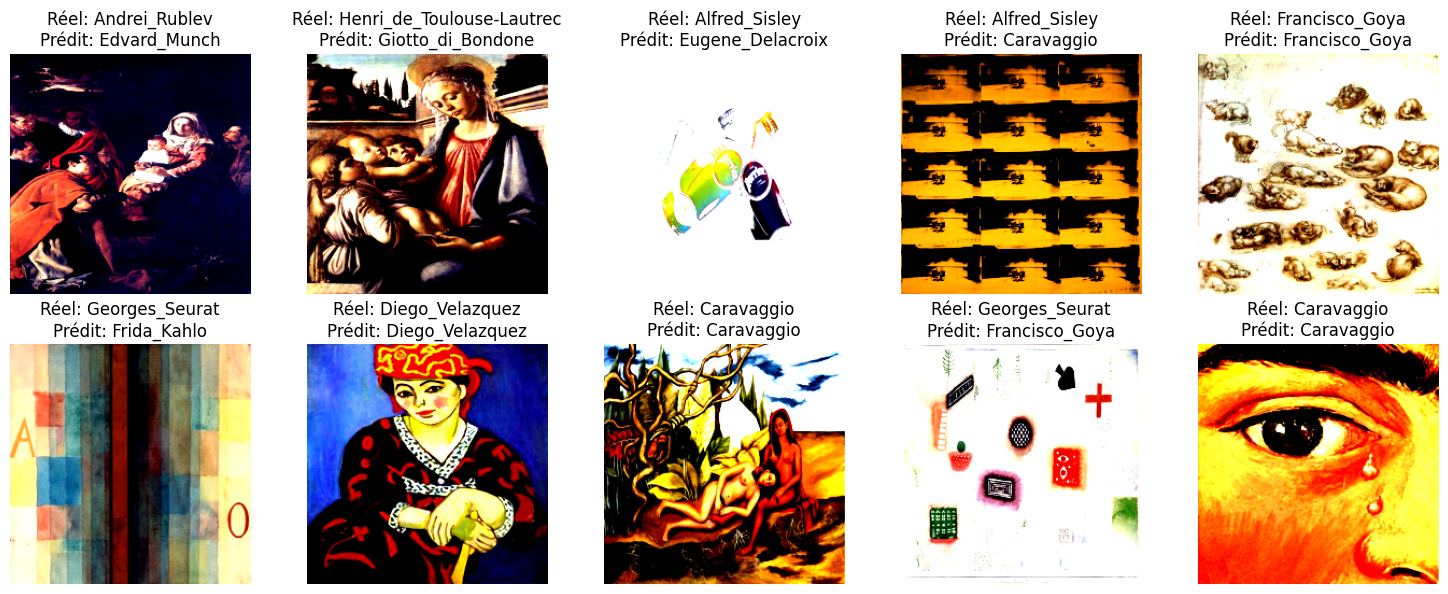

In [70]:
# Appeler la fonction pour afficher les images Avec le premier model : modelI
display_random_images_with_predictions(modelI, test_loader, class_names)

### Explication des résultats

La classification d'œuvres d'art par artiste est une tâche particulièrement complexe pour plusieurs raisons:

*   Les peintures varient énormément en termes de style, de couleur, de texture et de composition même au sein des œuvres d’un seul artiste
*   De nombreux artistes partagent des caractéristiques stylistiques communes

Ceci rend donc la distinction entre artistes difficile. Un modèle convolutionnel assez simple, avec quelques couches, comme construit précédement, manque de profondeur et de paramètres  pour capturer ces nuances artistiques ainsi les résulats sont peu satisfaisant et on obtient que 43% de prédiction juste sur le jeu de test.



### Amélioration

L'utilisation d'un réseau préentraîné, comme ResNet50, est donc recommandée dans un cas comme le notre. Les modèles comme ResNet50 sont beaucoup plus profonds et ont été préentraînés sur des bases de données massives (comme ImageNet), permettant d'apprendre une hiérarchie de caractéristiques visuelles très fines. Cette richesse dans les caractéristiques extraites est essentielle pour capturer les détails spécifiques des œuvres d'art et pour faire la différence entre les artistes. En transférant les connaissances d'un réseau préentraîné, notre modèle peut démarrer avec une compréhension plus approfondie des images, ce qui se traduit généralement par des performances de classification significativement améliorées.



## Prédiction avec transfer learning


In [34]:
from torchvision import models

# Chargement du modèle ResNet50 pré-entraîné
model = models.resnet50(pretrained=True)

# Geler les couches pour éviter de réentraîner les poids des couches pré-entraînées
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [35]:
# Modifier la dernière couche fully connected pour correspondre au nombre de classes (auteurs)
num_features = model.fc.in_features
num_classes = len(unique_artists)
model.fc = nn.Linear(num_features, num_classes)

# Déplacer le modèle vers le device
model = model.to(device)

In [46]:
# Définition des hyperparamètres
num_epochs = 15
batch_size = 64
learning_rate = 0.001
momentum = 0.9

In [47]:
# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=momentum)  # Optimisation uniquement de la dernière couche
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [48]:
train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Époque [1/15], Perte : 1.8779, Précision Validation : 60.24%
Époque [2/15], Perte : 1.7563, Précision Validation : 58.23%
Époque [3/15], Perte : 1.6531, Précision Validation : 59.84%
Époque [4/15], Perte : 1.5627, Précision Validation : 62.65%
Époque [5/15], Perte : 1.4795, Précision Validation : 63.05%
Époque [6/15], Perte : 1.4155, Précision Validation : 66.27%
Époque [7/15], Perte : 1.3521, Précision Validation : 63.05%
Époque [8/15], Perte : 1.3070, Précision Validation : 67.87%
Époque [9/15], Perte : 1.2598, Précision Validation : 65.06%
Époque [10/15], Perte : 1.2222, Précision Validation : 67.07%
Époque [11/15], Perte : 1.1858, Précision Validation : 67.87%
Époque [12/15], Perte : 1.1686, Précision Validation : 67.47%
Époque [13/15], Perte : 1.1429, Précision Validation : 67.87%
Époque [14/15], Perte : 1.1309, Précision Validation : 66.27%
Époque [15/15], Perte : 1.1137, Précision Validation : 67.87%


In [50]:
# Évaluation finale sur le jeu de test
test_accuracy, pred_label = evaluate(model, test_loader)
print(f"Taux de précision sur le jeu de test : {test_accuracy:.2f}%")

Taux de précision sur le jeu de test : 67.52%


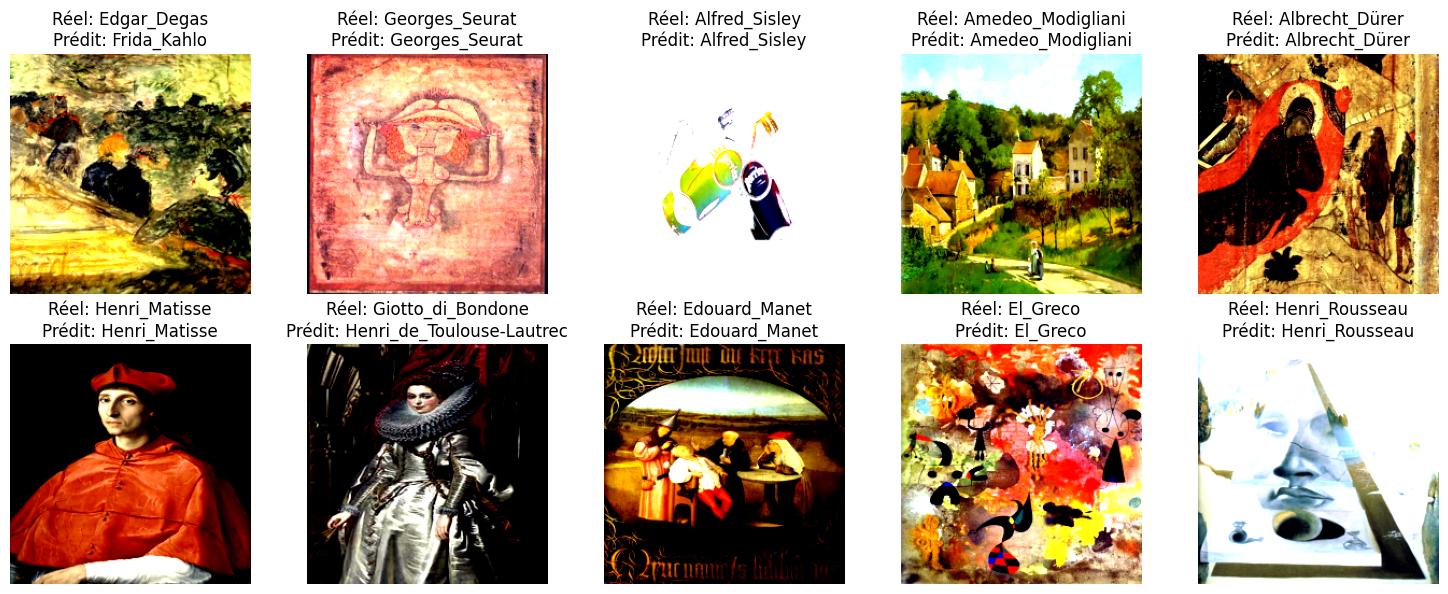

In [51]:
# Appeler la fonction pour afficher les images
display_random_images_with_predictions(model, test_loader, class_names)


### Analyse des résultats


En utilisantResNet50 comme modèle préentraîné, nous atteignons désormais une précision de 70 % sur la classification des artistes. Ce résultat, nettement plus élevé que celui obtenu avec le modèle convolutionnel simple, et il confirme bien l’efficacité du transfert d’apprentissage pour une tâche aussi complexe.

### Pistes d'amélioration





*   Augmentation des données : En appliquant des techniques de data augmentation, le modèle pourrait être mieux préparé à reconnaître les œuvres sous des perspectives et styles variés.
*   Finetuning plus approfondi : Adapter davantage les couches finales de ResNet50 aux spécificités des œuvres d’art et affiner les couches intermédiaires pourraient améliorer la précision du modèle.

* Exploration de caractéristiques contextuelles : En enrichissant le modèle avec des informations contextuelles, telles que le style artistique ou la période de création, on pourrait aider le modèle à affiner sa compréhension des différences subtiles entre les artistes.

### Data augmentation

In [73]:
from torchvision import transforms

# Transformations pour les données d'entraînement (Data Augmentation)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Crop aléatoire avec redimensionnement
    transforms.RandomHorizontalFlip(),                          # Flip horizontal
    transforms.RandomRotation(15),                              # Rotation aléatoire de ±15°
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),  # Ajustement aléatoire de la couleur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation pour ResNet
])

# Transformations pour les données de validation/test (sans Data Augmentation)
test_transforms = transforms.Compose([
    transforms.Resize(256),                                      # Redimensionnement pour ajuster les images
    transforms.CenterCrop(224),                                  # Crop central pour un format standard
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation pour ResNet
])


In [76]:
from torch.utils.data import DataLoader, Dataset, Subset

# Division du dataset en train et validation
train_indices, val_indices = train_test_split(
    range(len(art_datasetf)), test_size=0.1, random_state=42
)

# Création des sous-ensembles avec transformations
train_dataset2 = Subset(art_datasetf, train_indices)
val_dataset2 = Subset(art_datasetf, val_indices)

print(type(train_dataset2))
print(type(val_dataset2))

# Appliquer les transformations aux datasets
train_dataset2.dataset.transform = train_transforms
val_dataset2.dataset.transform = test_transforms

# Chargement des données avec DataLoader
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False)

<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


AttributeError: 'list' object has no attribute 'transform'


### Enregistrement du modèle



In [43]:
# Enregistrement du modèle
#torch.save(model.state_dict(), 'mon_modele_resnet.pth')

# Télécharger le fichier du modèle
#from google.colab import files
#files.download('mon_modele_resnet.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### test avec modèle enregistré